# Parameter Sweep for MPS Tomography

## Overview

This notebook extends the experiment from `MPSTomography_FASTV2.ipynb` to perform a parameter sweep over state preparation circuit depth (PSI_ANSATZ_DEPTH) and projector size (PROJECTOR_QUBIT_COUNT).

Key additions:
1. Sweep PSI_ANSATZ_DEPTH from 1 to 5
2. Sweep projector_qubit_count from 2 to 5
3. Run 5 trials for each parameter combination
4. Calculate average fidelity across trials
5. Generate comparative fidelity plot

In [1]:
## 1. Imports and Setup
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, state_fidelity
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_aer import AerSimulator

import itertools
import time

try:
    from scipy.optimize import minimize
except ModuleNotFoundError:
    print("ERROR: scipy is not installed. Please install it: pip install scipy")
    def minimize(*args, **kwargs):
        raise RuntimeError("scipy.optimize.minimize not found. Please install scipy.")

In [2]:
## 2. Configuration Parameters
# --- Main Experiment Configuration ---
NUM_QUBITS = 11
PSI_ANSATZ_DEPTH_RANGE = [1, 2, 3, 4, 5]
PROJECTOR_QUBIT_COUNT_RANGE = [2, 3, 4, 5]
NUM_TRIALS = 5

SCIPY_COBYLA_MAXITER = 5000
SCIPY_COBYLA_TOL = 1e-4
SEED = 42

print(f"--- Parameter Sweep for MPS Tomography ---")
print(f"Config: Qubits={NUM_QUBITS}, Trials={NUM_TRIALS}")
print(f"Sweeping PSI_ANSATZ_DEPTH over {PSI_ANSATZ_DEPTH_RANGE}")
print(f"Sweeping PROJECTOR_QUBIT_COUNT over {PROJECTOR_QUBIT_COUNT_RANGE}")

--- Parameter Sweep for MPS Tomography ---
Config: Qubits=11, Trials=5
Sweeping PSI_ANSATZ_DEPTH over [1, 2, 3, 4, 5]
Sweeping PROJECTOR_QUBIT_COUNT over [2, 3, 4, 5]


In [3]:
## 3. Core Function: Variational Optimization using EstimatorV2 (from original notebook)
def run_optimization_with_mps(
    num_qubits, 
    psi_preparation_circuit, 
    proj_qubit_count, 
    proj_u_reps, 
    run_seed,
    optimizer_tol,
    optimizer_maxiter
):
    """
    Finds the optimized projectors P* using the modern EstimatorV2 with an MPS simulator.
    """
    np.random.seed(run_seed)
    
    # Initialize Estimator with MPS backend
    estimator = AerEstimator(
        options={
            "backend_options": {
                "method": "matrix_product_state"
            },
            "run_options": {
                "shots": 10000,
                "seed": run_seed
            }
        }
    )

    qubit_groups = [tuple((i + j) % num_qubits for j in range(proj_qubit_count)) for i in range(num_qubits)]
    
    u_ansatz = TwoLocal(proj_qubit_count, ['ry', 'rz'], 'cx', 'linear', reps=proj_u_reps)
    num_u_params = u_ansatz.num_parameters
    
    optimized_projectors = []
    for q_group in qubit_groups:
        q_group_str = "".join(map(str, q_group))
        print(f"\n  Optimizing projector for group {q_group}...")

        vqa_circuit = psi_preparation_circuit.compose(u_ansatz.inverse(), qubits=list(q_group))
        vqa_circuit = vqa_circuit.decompose()
        s_i_full = ['I'] * num_qubits
        s_z_full_list = ['I'] * num_qubits
        for q_idx in q_group: s_z_full_list[q_idx] = 'Z'
        
        base_projector_spo = SparsePauliOp([
            "".join(s_i_full)[::-1],
            "".join(s_z_full_list)[::-1]
        ], coeffs=[0.5, 0.5])

        def cost_func(params):
            pub = (vqa_circuit, base_projector_spo, params)
            job = estimator.run(pubs=[pub])
            result = job.result()
            cost = result[0].data.evs
            print(f"    Cost for P_{q_group_str}: {cost:.6e}", end='\r')
            return np.real(cost)

        init_params = np.random.rand(num_u_params) * 2 * np.pi
        try:
            opt_res = minimize(
                fun=cost_func, x0=init_params, method='COBYLA',
                tol=optimizer_tol, options={'maxiter': optimizer_maxiter, 'disp': False}
            )
            
            print(f"\n    Optimization finished. Final cost: {opt_res.fun:.6e}")

            u_circ_opt = u_ansatz.assign_parameters(opt_res.x)
            u_op_opt = Operator(u_circ_opt)
            identity_full = Operator(np.eye(2**num_qubits))
            u_op_full = identity_full.compose(u_op_opt, qargs=list(q_group))
            p_star_op = u_op_full.adjoint().compose(base_projector_spo).compose(u_op_full)
            optimized_projectors.append(p_star_op)
            
        except Exception as e_opt:
            print(f"    ERROR: An exception occurred during optimization for P_{q_group_str}: {e_opt}")
            
    return optimized_projectors

In [4]:
## 4. Parameter Sweep and Main Experiment Loop
results = []  # Store (depth, proj_size, trial, fidelity)

for depth in PSI_ANSATZ_DEPTH_RANGE:
    for proj_size in PROJECTOR_QUBIT_COUNT_RANGE:
        # Calculate derived parameters
        PROJECTOR_RANK = 2**(proj_size - 1)
        PROJECTOR_U_REPS = proj_size - 1
        
        print(f"\n=== Starting parameter set: depth={depth}, proj_size={proj_size} ===")
        
        fidelities = []
        for trial in range(NUM_TRIALS):
            trial_seed = SEED + trial
            np.random.seed(trial_seed)
            
            print(f"\n** Trial {trial+1}/{NUM_TRIALS} **")
            
            # State preparation circuit (from original)
            psi_ansatz = RealAmplitudes(NUM_QUBITS, reps=depth, entanglement='linear')
            psi_params = np.random.rand(psi_ansatz.num_parameters) * 2 * np.pi
            psi_preparation_circuit_unbound = psi_ansatz.assign_parameters(psi_params)
            psi_preparation_circuit = psi_preparation_circuit_unbound.decompose()
            
            # Run optimization
            optimized_projectors_P_star = run_optimization_with_mps(
                NUM_QUBITS, psi_preparation_circuit, proj_size, 
                PROJECTOR_U_REPS, trial_seed, 
                SCIPY_COBYLA_TOL, SCIPY_COBYLA_MAXITER
            )
            
            if not optimized_projectors_P_star:
                print("Skipping due to failed optimization")
                fidelities.append(np.nan)
                continue
                
            # Build Hamiltonian and compute fidelity (from original)
            H_op = np.zeros((2**NUM_QUBITS, 2**NUM_QUBITS), dtype=np.complex128)
            for p_star in optimized_projectors_P_star:
                H_op += p_star.to_matrix()
            
            eigenvalues, eigenvectors = np.linalg.eigh(H_op)
            psi_gs_vector = Statevector(eigenvectors[:, 0])
            psi_initial_vector = Statevector(psi_preparation_circuit)
            fidelity = state_fidelity(psi_initial_vector, psi_gs_vector)
            
            print(f"\nFidelity for depth={depth}, proj_size={proj_size}, trial={trial+1}: {fidelity:.6f}")
            fidelities.append(fidelity)
            results.append((depth, proj_size, trial, fidelity))
        
        # Calculate average fidelity for this parameter set
        avg_fidelity = np.mean(fidelities)
        print(f"\n=== Average fidelity for depth={depth}, proj_size={proj_size}: {avg_fidelity:.6f} ===\n")


=== Starting parameter set: depth=1, proj_size=2 ===

** Trial 1/5 **

  Optimizing projector for group (0, 1)...


KeyboardInterrupt: 


=== Final Results ===
    depth  proj_size  fidelity
0       1          2  0.207756
1       1          3  0.784636
2       1          4  0.728592
3       1          5  0.657277
4       2          2  0.129356
5       2          3  0.276972
6       2          4  0.328116
7       2          5  0.383515
8       3          2  0.033172
9       3          3  0.038351
10      3          4  0.010249
11      3          5  0.142740
12      4          2  0.011870
13      4          3  0.034145
14      4          4  0.030848
15      4          5  0.067817
16      5          2  0.021774
17      5          3  0.009466
18      5          4  0.020339
19      5          5  0.006883


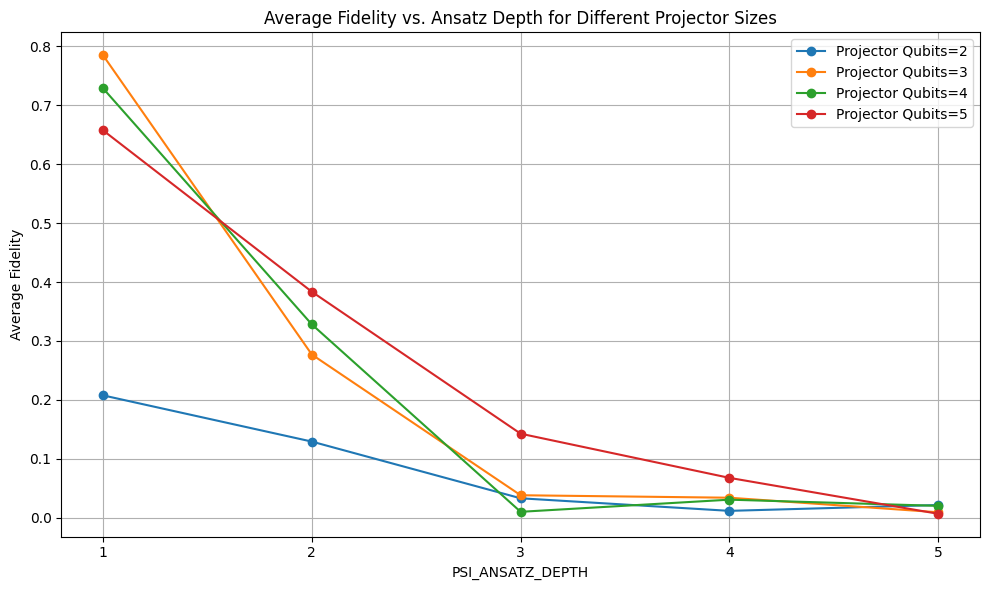


Plot saved as 'parameter_sweep_results.png'


In [ ]:
## 5. Results Analysis and Plotting
# Aggregate results
import pandas as pd

df = pd.DataFrame(results, columns=['depth', 'proj_size', 'trial', 'fidelity'])
avg_df = df.groupby(['depth', 'proj_size'])['fidelity'].mean().reset_index()

print("\n=== Final Results ===")
print(avg_df)

# Generate plot
plt.figure(figsize=(10, 6))

for proj_size in PROJECTOR_QUBIT_COUNT_RANGE:
    subset = avg_df[avg_df['proj_size'] == proj_size]
    plt.plot(subset['depth'], subset['fidelity'], 
             marker='o', linestyle='-', 
             label=f'Projector Qubits={proj_size}')

plt.xlabel('PSI_ANSATZ_DEPTH')
plt.ylabel('Average Fidelity')
plt.title('Average Fidelity vs. Ansatz Depth for Different Projector Sizes')
plt.xticks(PSI_ANSATZ_DEPTH_RANGE)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig('parameter_sweep_results.png', dpi=300)
plt.show()

print("\nPlot saved as 'parameter_sweep_results.png'")